# Notebook 06: Model Training - Malaysia

Train Lasso, Random Forest, and XGBoost models on Malaysia data.\
Compare performance metrics.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import pickle
import os
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(42)

## Load Prepared Data

In [ ]:
X_malaysia = pd.read_csv('data/processed/malaysia_X_scaled.csv')
y_malaysia = pd.read_csv('data/processed/malaysia_y.csv').values.ravel()

print(f"Malaysia training data loaded:")
print(f"  X shape: {X_malaysia.shape}")
print(f"  y shape: {y_malaysia.shape}")

# Split
X_train_my, X_val_my, y_train_my, y_val_my = train_test_split(
    X_malaysia, y_malaysia, test_size=0.2, random_state=42
)

print(f"\nTrain/Val split:")
print(f"  Train: {X_train_my.shape} samples")
print(f"  Val: {X_val_my.shape} samples")

Malaysia training data loaded:
  X shape: (1877, 2180)
  y shape: (1877,)

Train/Val split:
  Train: (1501, 2180) samples
  Val: (376, 2180) samples


In [14]:
# Remove 'Median_PSF' from X_malaysia and any existing train/val splits (safe no-op if missing)
col = "Median_PSF"
print("Before:", X_malaysia.shape, "contains column:", col in X_malaysia.columns)

X_malaysia.drop(columns=[col], inplace=True, errors='ignore')

for df_name in ("X_train_my", "X_val_my"):
    if df_name in globals():
        globals()[df_name].drop(columns=[col], inplace=True, errors='ignore')

print("After:", X_malaysia.shape, "train shape:", X_train_my.shape, "val shape:", X_val_my.shape)

Before: (1877, 2180) contains column: True
After: (1877, 2179) train shape: (1501, 2179) val shape: (376, 2179)


`Median_PSF` feature is the exact hint for the model. It doesn't find the relations in data, just calculates price, using this. So for fair training, we should remove this column.

## Train Lasso Model

In [15]:
print("Training Lasso...")
lasso_my = Lasso(alpha=5000, random_state=42, max_iter=5000)
lasso_my.fit(X_train_my, y_train_my)

y_pred_lasso_my = lasso_my.predict(X_val_my)

r2_lasso_my = r2_score(y_val_my, y_pred_lasso_my)
rmse_lasso_my = np.sqrt(mean_squared_error(y_val_my, y_pred_lasso_my))
mae_lasso_my = mean_absolute_error(y_val_my, y_pred_lasso_my)

print(f"R² Score: {r2_lasso_my:.4f} | RMSE: RM {rmse_lasso_my:,.0f} | MAE: RM {mae_lasso_my:,.0f}")

Training Lasso...
R² Score: 0.3200 | RMSE: RM 170,805 | MAE: RM 126,425


## Train Random Forest Model

In [16]:
print("Training Random Forest...")
rf_my = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_my.fit(X_train_my, y_train_my)

y_pred_rf_my = rf_my.predict(X_val_my)

r2_rf_my = r2_score(y_val_my, y_pred_rf_my)
rmse_rf_my = np.sqrt(mean_squared_error(y_val_my, y_pred_rf_my))
mae_rf_my = mean_absolute_error(y_val_my, y_pred_rf_my)

print(f"R² Score: {r2_rf_my:.4f} | RMSE: RM {rmse_rf_my:,.0f} | MAE: RM {mae_rf_my:,.0f}")

Training Random Forest...
R² Score: 0.3714 | RMSE: RM 164,222 | MAE: RM 118,821


## Train XGBoost Model

In [17]:
print("Training XGBoost...")
xgb_my = XGBRegressor(n_estimators=150, max_depth=6, learning_rate=0.15, random_state=42)
# sanitize feature names (XGBoost disallows '[', ']' and '<') then fit
X_train_my.columns = X_train_my.columns.astype(str).str.replace(r'[\[\]<>]', '_', regex=True)
X_val_my.columns = X_val_my.columns.astype(str).str.replace(r'[\[\]<>]', '_', regex=True)
xgb_my.fit(X_train_my, y_train_my, verbose=False)

y_pred_xgb_my = xgb_my.predict(X_val_my)

r2_xgb_my = r2_score(y_val_my, y_pred_xgb_my)
rmse_xgb_my = np.sqrt(mean_squared_error(y_val_my, y_pred_xgb_my))
mae_xgb_my = mean_absolute_error(y_val_my, y_pred_xgb_my)

print(f"R² Score: {r2_xgb_my:.4f} | RMSE: RM {rmse_xgb_my:,.0f} | MAE: RM {mae_xgb_my:,.0f}")

Training XGBoost...
R² Score: 0.4271 | RMSE: RM 156,786 | MAE: RM 114,488


## Model Comparison


Model Comparison (Malaysia):
        Model  R2_Score          RMSE           MAE
      XGBoost  0.427060 156786.100547 114488.230448
Random Forest  0.371423 164222.355872 118821.442701
        Lasso  0.320025 170804.517528 126424.887167


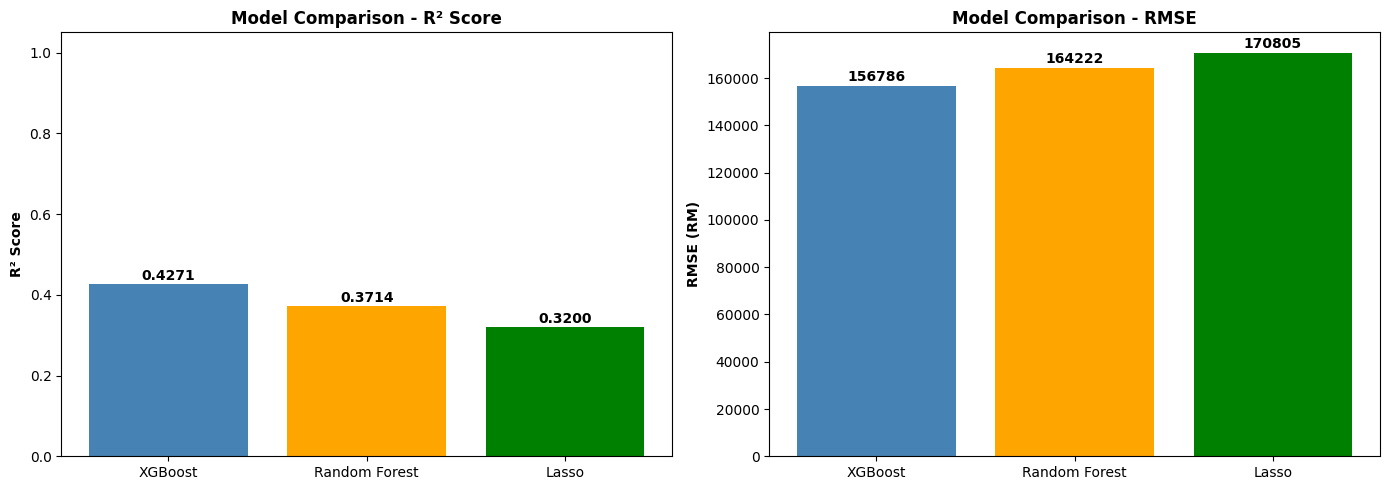

In [18]:
import matplotlib.pyplot as plt

comparison_my = pd.DataFrame({
    'Model': ['Lasso', 'Random Forest', 'XGBoost'],
    'R2_Score': [r2_lasso_my, r2_rf_my, r2_xgb_my],
    'RMSE': [rmse_lasso_my, rmse_rf_my, rmse_xgb_my],
    'MAE': [mae_lasso_my, mae_rf_my, mae_xgb_my]
})

comparison_my = comparison_my.sort_values('R2_Score', ascending=False)

print("\nModel Comparison (Malaysia):")
print(comparison_my.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(comparison_my['Model'], comparison_my['R2_Score'], color=['steelblue', 'orange', 'green'])
axes[0].set_ylabel('R² Score', fontweight='bold')
axes[0].set_title('Model Comparison - R² Score', fontweight='bold')
axes[0].set_ylim([0, 1.05])

for i, v in enumerate(comparison_my['R2_Score']):
    axes[0].text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

axes[1].bar(comparison_my['Model'], comparison_my['RMSE'], color=['steelblue', 'orange', 'green'])
axes[1].set_ylabel('RMSE (RM)', fontweight='bold')
axes[1].set_title('Model Comparison - RMSE', fontweight='bold')

for i, v in enumerate(comparison_my['RMSE']):
    axes[1].text(i, v + 2000, f'{v:.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

**R² Score Comparison:**
**XGBoost** achieves the highest accuracy with an R² score of **0.43**, significantly outperforming Random Forest (0.37) and Lasso (0.32), although the overall lower scores confirm that predicting prices based solely on location is challenging.

**RMSE Comparison:**
The error chart validates XGBoost as the most reliable model with the lowest average error of **156,786 RM**, whereas Lasso produces the highest error (**170,805 RM**), struggling to capture the complex price variations in different states.

## Save Metrics

In [ ]:
path = 'results/model_metrics.csv'
malaysia_metrics = pd.DataFrame({
    'Dataset': ['Malaysia', 'Malaysia', 'Malaysia'],
    'Model': ['Lasso', 'Random Forest', 'XGBoost'],
    'R2_Score': [r2_lasso_my, r2_rf_my, r2_xgb_my],
    'RMSE': [rmse_lasso_my, rmse_rf_my, rmse_xgb_my],
    'MAE': [mae_lasso_my, mae_rf_my, mae_xgb_my]
})

# Read existing metrics if file exists
if os.path.exists(path):
    existing_metrics = pd.read_csv(path)
    # If Malaysia already present in Dataset column, skip appending
    if 'Malaysia' in existing_metrics['Dataset'].values:
        print("Malaysia metrics already present in results/model_metrics.csv. Skipping append.")
    else:
        # Read existing metrics and append
        existing_metrics = pd.read_csv(path)
        combined_metrics = pd.concat([existing_metrics, malaysia_metrics], ignore_index=True)

        # Save combined metrics
        combined_metrics.to_csv(path, index=False)

        print("Malaysia metrics appended to results/model_metrics.csv")
        print("Complete metrics table:")
        print(combined_metrics.to_string(index=False))
else:
    malaysia_metrics.to_csv('results/model_metrics.csv', index=False)

    print("Metrics saved to results/model_metrics.csv")
    print(malaysia_metrics.to_string(index=False))

Malaysia metrics already present in results/model_metrics.csv. Skipping append.


## Save Models

In [ ]:
os.makedirs('results/models', exist_ok=True)

with open('results/models/malaysia_lasso_model.pkl', 'wb') as f:
    pickle.dump(lasso_my, f)

with open('results/models/malaysia_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_my, f)

with open('results/models/malaysia_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_my, f)

print("Models saved:")
print("  - malaysia_lasso_model.pkl")
print("  - malaysia_rf_model.pkl")
print("  - malaysia_xgb_model.pkl")

Models saved:
  - malaysia_lasso_model.pkl
  - malaysia_rf_model.pkl
  - malaysia_xgb_model.pkl


## Training Summary

In [21]:
print("MALAYSIA MODEL TRAINING SUMMARY")
    
print(f"Best Model: {comparison_my.iloc[0]['Model']}")
print(f"R² Score: {comparison_my.iloc[0]['R2_Score']:.4f}")
print(f"RMSE: RM {comparison_my.iloc[0]['RMSE']:,.0f}")
print(f"MAE: RM {comparison_my.iloc[0]['MAE']:,.0f}")

MALAYSIA MODEL TRAINING SUMMARY
Best Model: XGBoost
R² Score: 0.4271
RMSE: RM 156,786
MAE: RM 114,488
